## Dane

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

import PIL

import seaborn as sns
sns.set(style='whitegrid',font_scale=1.5)

import tensorflow_datasets as tfds

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
(ds_train, ds_val),info = tfds.load(
    "resisc45",
    split=["train[:70%]", "train[70%:100%]"],
    as_supervised=True,  # Include labels
    with_info=True
)

print('Train:',len(ds_train))
print('Val:',len(ds_val))

Train: 22050
Val: 9450


In [3]:
class_names = info.features['label'].names

num_classes = len(class_names)
num_classes

45

In [4]:
img_size = 256
batch_size=32

size = (img_size, img_size)

ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(lambda image, label: (tf.image.resize(image, size), label))
ds_val = ds_val.batch(batch_size=batch_size, drop_remainder=True)

## Model + confusion matrix

In [5]:
# lekcja 8.03

from sklearn.metrics import confusion_matrix

In [6]:
def getModel():
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(8, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes, activation='softmax')], name='GlobalAveragePooling')
        
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [7]:
epochs = 5

In [8]:
model = getModel()
history = model.fit(ds_train, epochs=epochs, batch_size=batch_size, validation_data=(ds_val), verbose=1)

Epoch 1/5
689/689 [==============================] - 413s 600ms/step - loss: 2.8935 - accuracy: 0.2475 - val_loss: 2.2576 - val_accuracy: 0.3606
Epoch 2/5
689/689 [==============================] - 412s 599ms/step - loss: 2.0819 - accuracy: 0.4138 - val_loss: 1.9638 - val_accuracy: 0.4458
Epoch 3/5
689/689 [==============================] - 409s 594ms/step - loss: 1.7893 - accuracy: 0.4881 - val_loss: 1.7697 - val_accuracy: 0.4992
Epoch 4/5
689/689 [==============================] - 411s 596ms/step - loss: 1.5881 - accuracy: 0.5396 - val_loss: 1.5679 - val_accuracy: 0.5561
Epoch 5/5
689/689 [==============================] - 413s 599ms/step - loss: 1.4487 - accuracy: 0.5759 - val_loss: 1.4962 - val_accuracy: 0.5753


In [9]:
ds_pred = model.predict(ds_val)

In [10]:
predicted_classes = tf.argmax(ds_pred, axis=1)

In [11]:
true_classes = tf.concat([y for x, y in ds_val], axis=0)

In [12]:
cm = confusion_matrix(predicted_classes, true_classes)

In [13]:
cm

array([[178,   8,   5, ...,  13,   7,   0],
       [  0, 106,   2, ...,  13,   3,   0],
       [  0,   0,  80, ...,   1,   0,   0],
       ...,
       [  0,   8,   1, ..., 141,   4,   5],
       [  2,   8,   0, ...,   3,  98,   0],
       [  0,   0,   0, ...,   0,   0,  56]], dtype=int64)

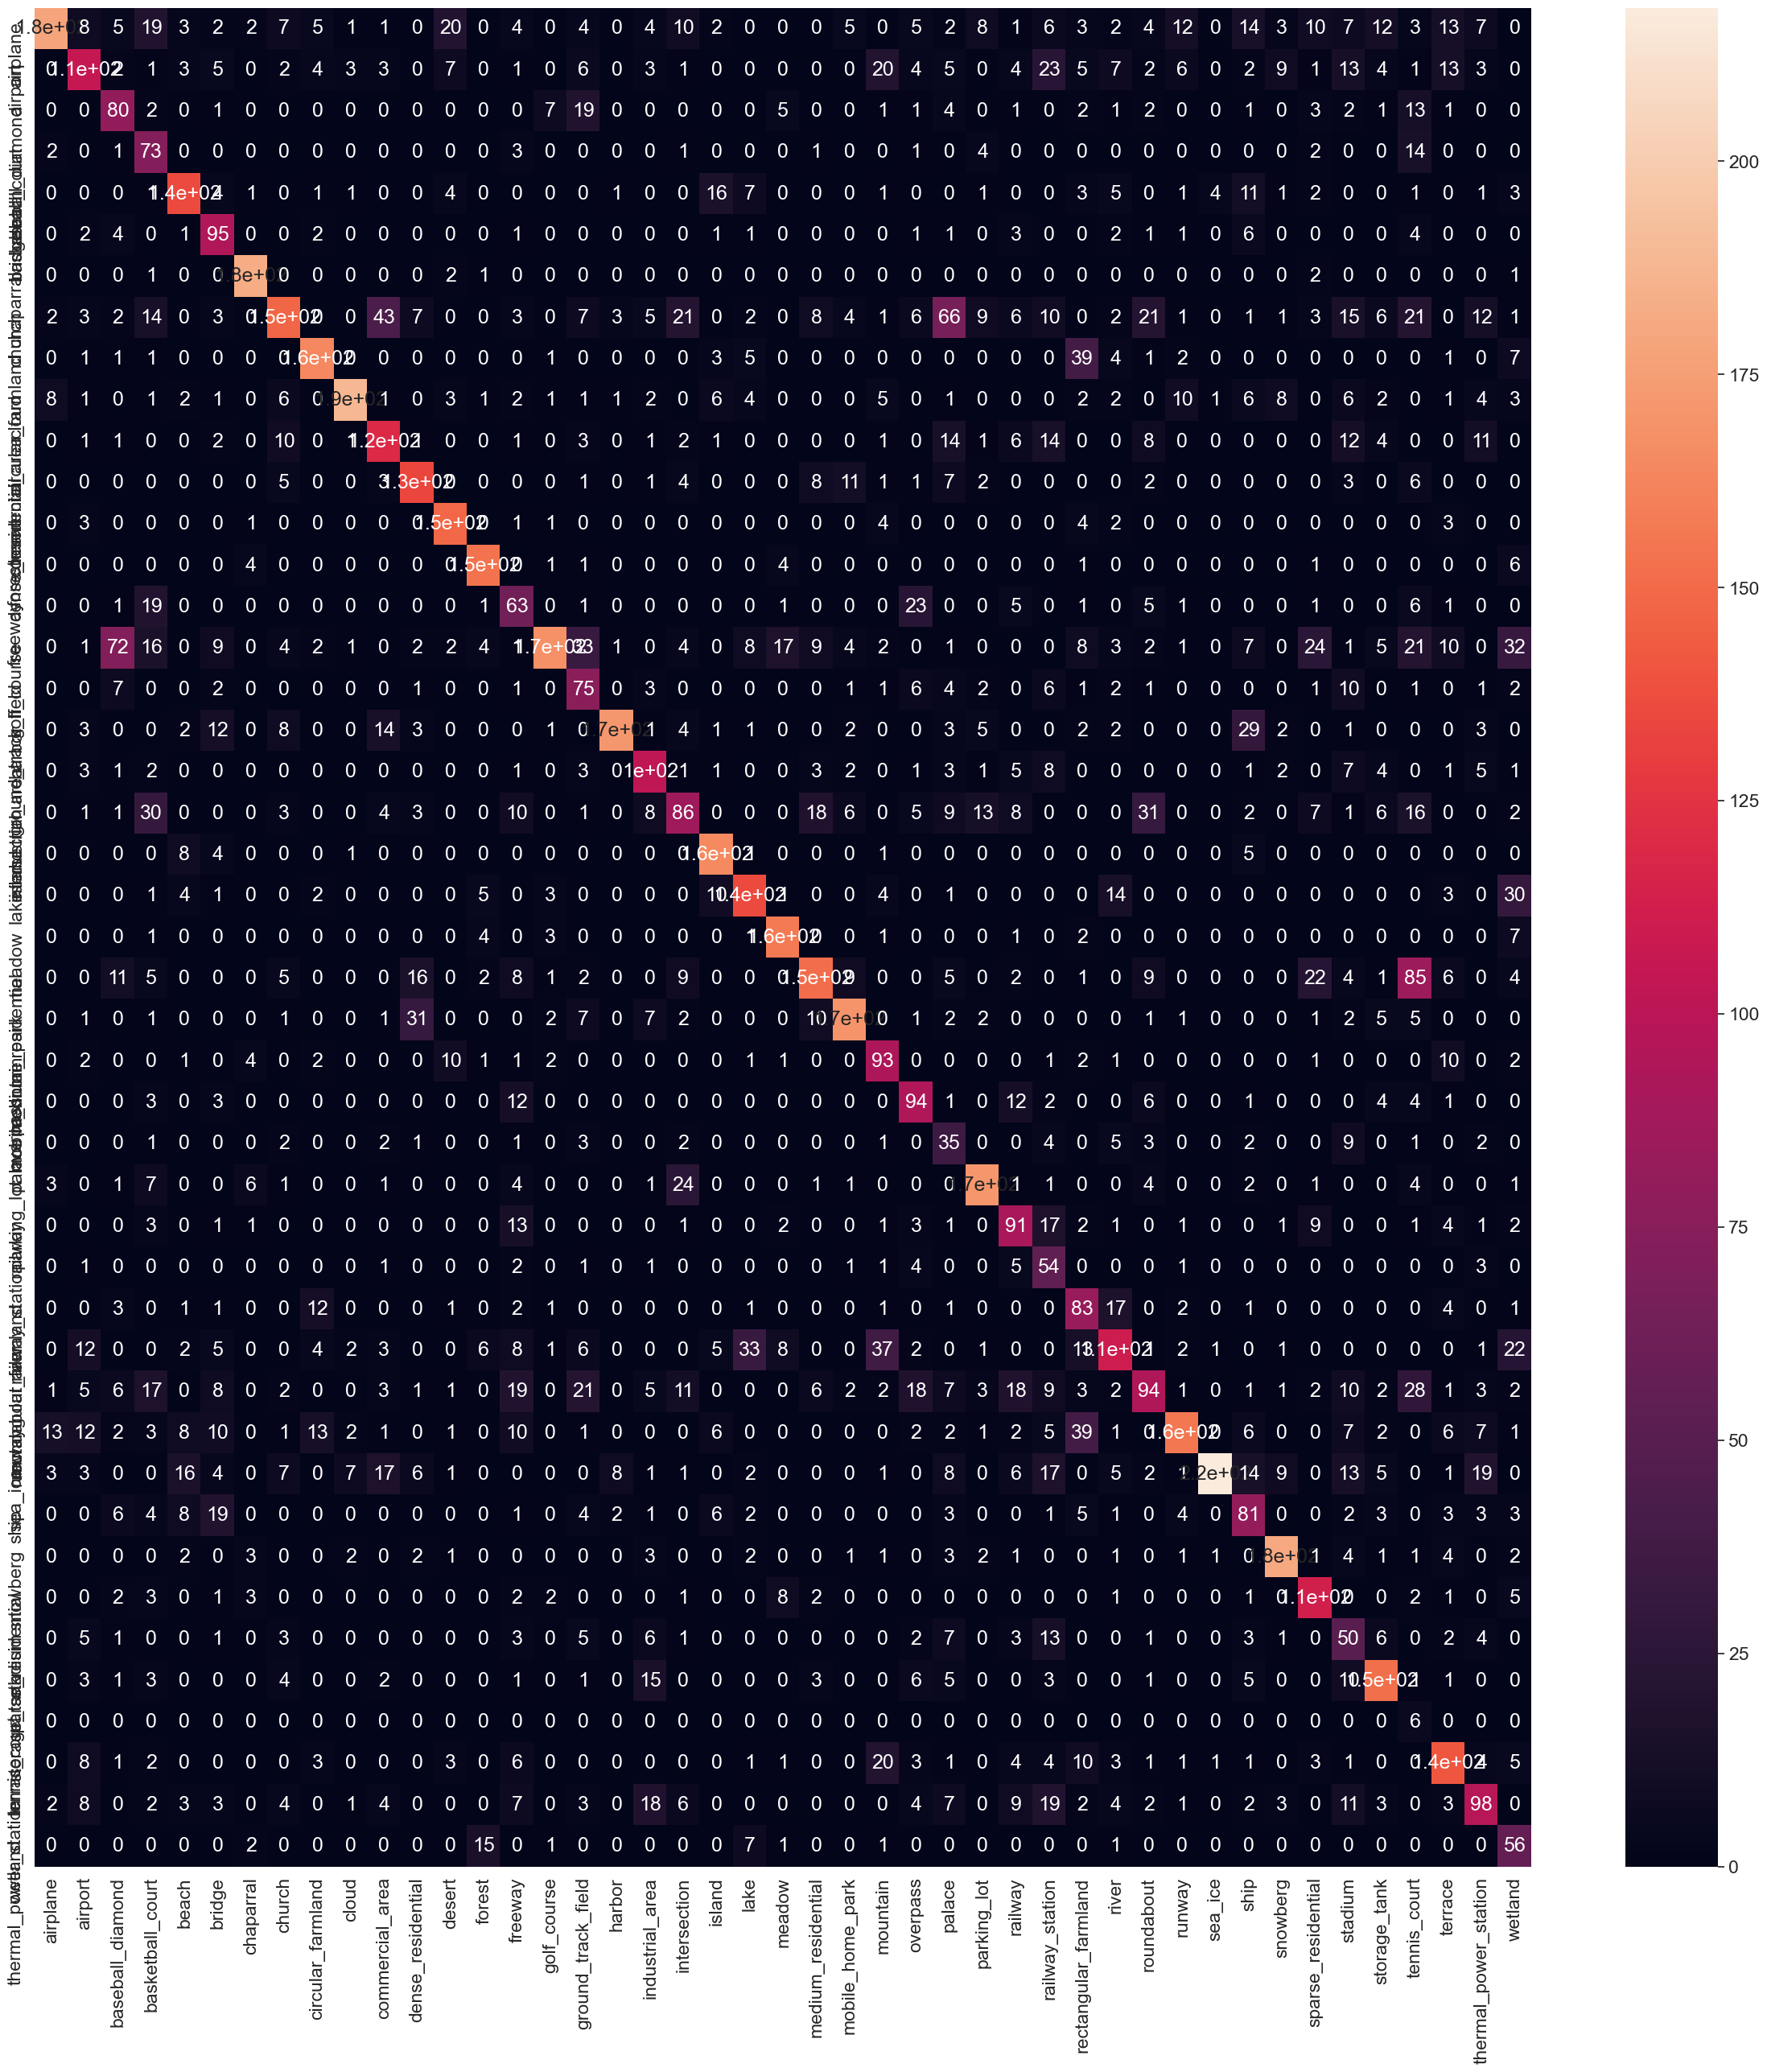

In [14]:
plt.figure(figsize=(30,30))
sns.heatmap(cm, annot=True);
plt.xticks(np.arange(0.5,45.5),class_names, rotation = 90) #nie umiem obrócić tych labelek
plt.yticks(np.arange(0.5,45.5),class_names, rotation = 90)
plt.show();